Reviewed: Jan 2024

This notebook may be run in Colab

To run this code on the GPU:

**Runtime -> Change runtime type -> GPU**

# Building a NN using PyTorch

Given an image of a clothing item, we will predict the item.
We will show how to add layers to a NN using [nn.Torch](https://pytorch.org/docs/stable/nn.html), and [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) which
is an ordered container of modules. The data is passed through all the modules in the same order as defined.

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim   # SGD
import time

In [2]:
#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

False

## The Fashion MNIST data

We will use 4096 training images, and 1024 validation images. (Normally, when we train neural networks, we will try to use all the data that we have. The only reason I'm limiting our training and validation set is so that the code runs quickly for demonstration purposes.)

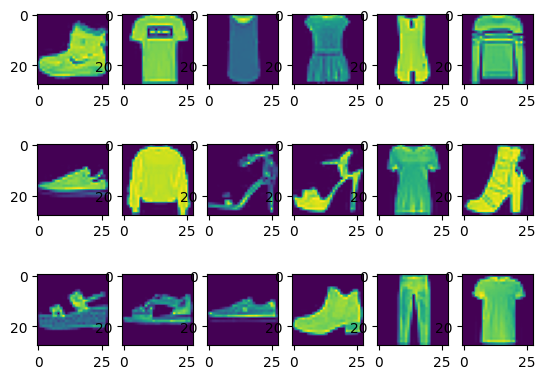

In [3]:
mnist_images = datasets.FashionMNIST('data', train=True, download=True)

for k, (image, label) in enumerate(mnist_images):
    if k >= 18:
        break
    plt.subplot(3, 6, k+1)
    plt.imshow(image)

In [4]:
#Convert to images to tensor format. The data has been downloaded in the previous code
# chunk `download=True`, so no need to download again here.
mnist_data = datasets.FashionMNIST('data', train=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)

mnist_train = mnist_data[:4096]
mnist_val   = mnist_data[4096:5120]

In [5]:
# no. obs in train and validation sets
len(mnist_train), len(mnist_val)

(4096, 1024)

## The model

[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) is the base class for **all** NN modules. It contains the methods for NN training.

[nn.Sequential]((https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) is a subclass of NN.Module.
It allows for chaining of the layers and is a quick way to build a NN when this is allowed.

Depending on the architecture of the NN, we may use nn.Module, or nn.Sequential, or both to build our model.

Here, we will fit a softmax regression, which chaining together a vectorised layer and a linear layer. (There is a softmax operation which we will discuss shortly).

Each image is 28 x 28.

Define the model `model` so that and input image is:

**flattened (vectorised) --> linear layer that has 10 outputs -->Classify with softmax.**

PyTorch does not implicitly reshape the inputs. Thus define the flatten
layer [`nn.Flatten()`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to reshape the inputs (to a vector) before the linear layer in the network.

In [6]:
model = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 10))

In [8]:
# try a complex model

model = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 10)
                    #   ,nn.LeakyReLU(),
                    #   nn.Linear(64, 32),
                    #   nn.LeakyReLU(),
                    #   nn.Linear(32, 10)
                      )

## **Test the model**

Good idea to feed in one data point to see that it produces an
output of the expected shape.

In [7]:
input = torch.randn((1,28,28))# 1 channel of 28 x 28 pixels
output = model(input)
print(output.shape) # expect output is 1 x 10

torch.Size([1, 10])


In [8]:
#Or test it by feeding in first image
first_img, first_label = mnist_train[0]
print(first_img.shape)

output = model(first_img)
print(output)
print(output.shape)

torch.Size([1, 28, 28])
tensor([[-0.1128,  0.1684,  0.3090,  0.4029, -0.1130,  0.1233,  0.5520, -0.7118,
         -0.2351,  0.2090]], grad_fn=<AddmmBackward0>)
torch.Size([1, 10])


The tensor output shows the activation of the 10 output neurons in our neural network. We still need to go from this output to either a (discrete) prediction, or a (continuous) distribution showing a computed probability of the image belonging to each class (each digit).

The output of the linear layer, the logits, is passed through a softmax function to obtain probabilities - this is handled by [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) so we do not add it into our chain.


In [9]:
#How many weight parameters and bias terms in nn.Linear(28*28,10)?

fc = nn.Linear(28*28, 10)
fc_params = list(fc.parameters())
print("len(fc_params)", len(fc_params)) # weight and bias parameters
print("Weights:", fc_params[0].shape)   # 784 x 10 weights
print("Biases:", fc_params[1].shape)    # 10 bias terms

len(fc_params) 2
Weights: torch.Size([10, 784])
Biases: torch.Size([10])


In [10]:
#This is optional.
# Do not run this if you wish to use the default setting to initialise
# the parameters in nn.torch
def init_weights(m):
    "Initialise weights to the linear layer"
    if type(m) == nn.Linear:
        #nn.init.normal_(tensor=m.weight, mean=0.0,std=0.01)
        #nn.init.zeros_(tensor=m.weight)
        #nn.init.zeros_(tensor=m.bias)
        #nn.init.ones_(tensor=m.weight)
        nn.init.xavier_normal_(tensor=m.weight)

model.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

In [11]:
#Displays model parameters
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0294, -0.0422,  0.0206,  ..., -0.0052, -0.0810,  0.1214],
        [-0.0027, -0.0638,  0.0218,  ..., -0.0094, -0.0560, -0.0537],
        [ 0.0033, -0.0013,  0.0094,  ..., -0.0460,  0.0462, -0.0072],
        ...,
        [ 0.0898,  0.0808,  0.0105,  ..., -0.0058, -0.0245,  0.0105],
        [-0.0238, -0.0362, -0.0658,  ...,  0.0754,  0.0582,  0.0025],
        [ 0.0813, -0.0027,  0.0253,  ..., -0.0859,  0.0382, -0.0607]],
       requires_grad=True), Parameter containing:
tensor([-0.0047,  0.0156,  0.0157, -0.0303,  0.0351,  0.0186,  0.0095, -0.0250,
         0.0047, -0.0214], requires_grad=True)]


If we run the forward pass -- or attempt to make predictions, we will get something like this:

In [12]:
# For this class, it's optional to use the GPU

#Set up device to do computation. Device is either cpu or gpu.
#Set device = gpu if gpu available
device = torch.device("cuda" if cuda else "cpu")

#Transfer model to device. (Also have to transfer data to device, which will do later)
model.to(device)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


## Training

In [19]:
num_workers = 3 if cuda else 0

def train(model, data, batch_size=64, num_epochs=1, num_workers=num_workers):
    """
    For num_epoch of times, iterate over the mini-batches and
    and update the parameters at each iteration.
    Record the training loss, and validation error, and plot each over iterations.
    At the start of each epoch the data is shuffled and a new set of
    mini-batches is created.

    Parameters:
        model: the neural net
        batch_size (int): mini-batch size of training and validation sets
        num_epochs(int): number of epochs to train

    Returns:
        None
    """

    train_loader = torch.utils.data.DataLoader(data,
                                               batch_size=batch_size,
                                               shuffle=True, 
                                               num_workers=num_workers)

    # Pick loss and optimiser to use in training
    # Inialise loss
    criterion = nn.CrossEntropyLoss()
    # Initialise optimizer
    optimizer = optim.SGD(model.parameters(), 
                          # momentum=0.2, 
                          lr=1e-2) # In Week 5 we will see variants of SGD that perform better than SGD
    # optim.Adam()

    # Store evaluation metrics
    iters, losses, train_acc, val_acc = [], [], [], []

    # Training loop
    n = 0 # the number of iterations
    start_time = time.time()

    for epoch in range(num_epochs):
        #Iterate over the mini-batches
        for imgs, labels in iter(train_loader):
            running_loss = 0.0

            # Transfer data to device
            imgs = imgs.to(device)
            labels = labels.to(device)

            #Forward pass: outputs logits for each image and computes the loss value
            out = model(imgs)
            loss = criterion(out, labels)
            running_loss += loss.item() # record sum of losses over mini-batches

            #Backward pass and update
            loss.backward()               # Backprop
            optimizer.step()              # Update each parameter
            optimizer.zero_grad()         # reset gradients

        # Save the current training information to report
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train=True)) # compute training accuracy
        val_acc.append(get_accuracy(model, train=False))  # compute validation accuracy
        n += 1
        
        #End of an epoch
        end_time = time.time()
        running_loss /= len(train_loader)
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {round(losses[-1],5)}, Time: {round(end_time - start_time,5)}s')

    #Ran through all epochs. Exit outer for loop. Plot results
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

`get_accuracy` helper function. To turn the probabilities into a discrete prediction, we will take the digit with the highest probability. Because of the way softmax is computed, the digit with the highest probability is the same as the digit with the (pre-activation) output value.

In [20]:
#train_acc_loader = torch.utils.data.DataLoader(mnist_train, batch_size=4096, shuffle=True)
#val_acc_loader = torch.utils.data.DataLoader(mnist_val, batch_size=1024, shuffle=False)

def get_accuracy(model, train=False):
    """
    Computes the accuracy of the training data (train=True), and validation
    data (train=False). Accuracy is defined as number correct predictions/ Total
    number of predictions made.

    This function is called from inside the training loop.

    Returns accuracy, a scalar.
    """
    if train:
        data = mnist_train
    else:
        data = mnist_val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        # Transfer data to device
        imgs = imgs.to(device)
        labels = labels.to(device)

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

## Debugging

One technique that researchers often use to debug their network is to first make sure that their network can overfit to a small dataset. This sanity check ensures that you are using the right variable names, and rules out other programming bugs that are difficult to discern from architecture issues.

Common programming issues that can arise include:

Forgetting to call optimizer.zero_grad() when using PyTorch. In general, this line of code is included at the beginning of the code for a training iteration, as opposed to at the end.
Using the wrong criterion, or using a loss function with incorrectly formated variables.
Adding a non-linearity after the final layer. In general we don't add a non-linearity in the forward function of the network, so that the computation of the loss function and the associated optimization steps are more numerically stable.
Forgetting non-linearity layers in the forward function.

Training Loss in epoch 1/10: 0.0387, Time: 0.10118s
Training Loss in epoch 2/10: 0.03754, Time: 0.11039s
Training Loss in epoch 3/10: 0.03654, Time: 0.11875s
Training Loss in epoch 4/10: 0.03567, Time: 0.12706s
Training Loss in epoch 5/10: 0.03491, Time: 0.13903s
Training Loss in epoch 6/10: 0.03423, Time: 0.14749s
Training Loss in epoch 7/10: 0.03364, Time: 0.15547s
Training Loss in epoch 8/10: 0.0331, Time: 0.16371s
Training Loss in epoch 9/10: 0.03261, Time: 0.1722s
Training Loss in epoch 10/10: 0.03217, Time: 0.1864s


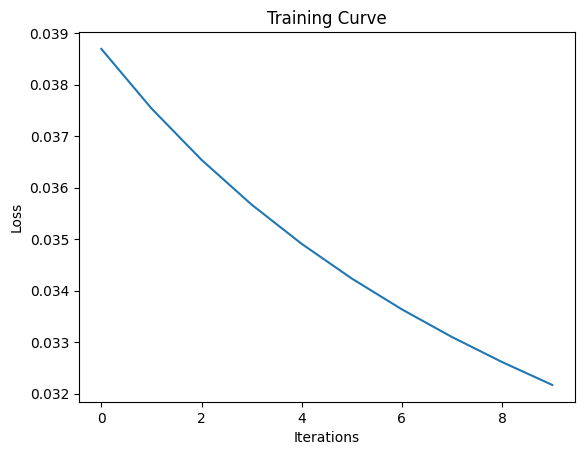

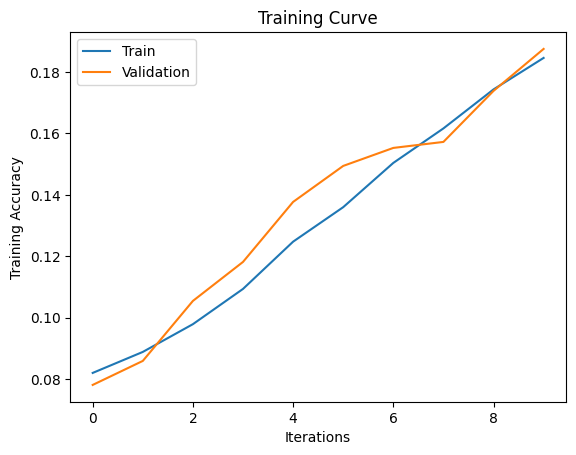

Final Training Accuracy: 0.1845703125
Final Validation Accuracy: 0.1875


In [15]:
debug_data = mnist_train[:64] #sample size = batch size
train(model, debug_data, batch_size=64, num_epochs=10)

Only when we have ensured that our model can overfit to a small dataset do we begin training the neural network our full training set.

Training Loss in epoch 1/500: 0.02377, Time: 0.07178s
Training Loss in epoch 2/500: 0.0177, Time: 0.09626s
Training Loss in epoch 3/500: 0.017, Time: 0.12399s
Training Loss in epoch 4/500: 0.01569, Time: 0.1445s
Training Loss in epoch 5/500: 0.0148, Time: 0.1682s
Training Loss in epoch 6/500: 0.01253, Time: 0.19283s
Training Loss in epoch 7/500: 0.01477, Time: 0.21821s
Training Loss in epoch 8/500: 0.01371, Time: 0.23927s
Training Loss in epoch 9/500: 0.01131, Time: 0.26193s
Training Loss in epoch 10/500: 0.0131, Time: 0.28493s
Training Loss in epoch 11/500: 0.01132, Time: 0.31589s
Training Loss in epoch 12/500: 0.01215, Time: 0.33621s
Training Loss in epoch 13/500: 0.0131, Time: 0.36286s
Training Loss in epoch 14/500: 0.01299, Time: 0.38875s
Training Loss in epoch 15/500: 0.01104, Time: 0.41312s
Training Loss in epoch 16/500: 0.0115, Time: 0.43355s
Training Loss in epoch 17/500: 0.00978, Time: 0.46249s
Training Loss in epoch 18/500: 0.00955, Time: 0.49496s
Training Loss in epoch 19/50

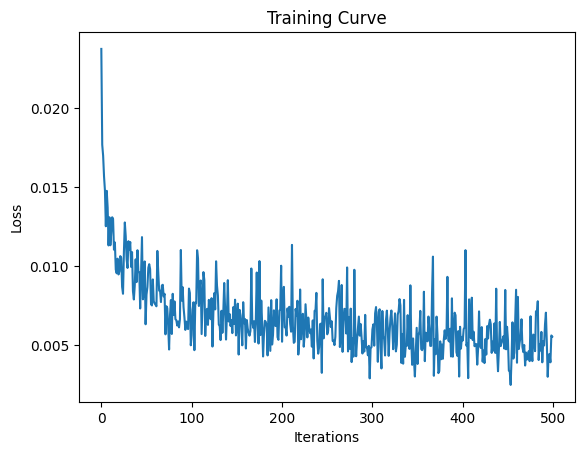

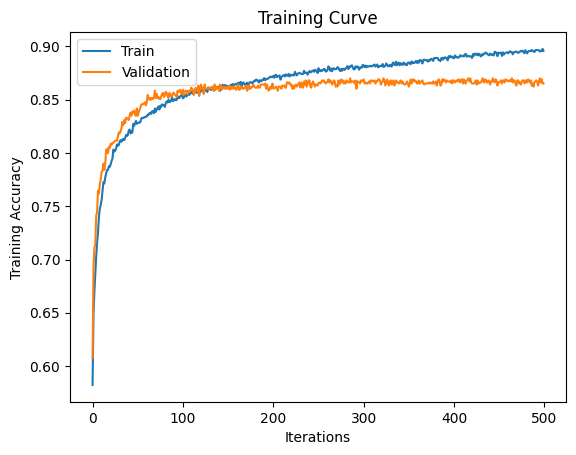

Final Training Accuracy: 0.89599609375
Final Validation Accuracy: 0.865234375


In [22]:
model = nn.Sequential(nn.Flatten(), 
                      nn.Linear(28*28, 10))
model.apply(init_weights)
train(model, mnist_train, batch_size=64, num_epochs=500)

# Saving and loading the model

In [23]:
#Save the model into your working directory
#Download it to your machine. (Or you can save it to Drive)
torch.save(model.state_dict(), 'FashionMnist_checkpoint.pth')

In [24]:
#Reloading the saved model
model = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 10)) #This should be the model you trained.
model.load_state_dict(torch.load('FashionMnist_checkpoint.pth'))
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


/var/folders/15/8lcxwsvj7ql4y4cmdw2m1_y00000gn/T/ipykernel_90957/3361761795.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('FashionMnis

In [25]:
#You would not do this, but as we have a small NN we can print out
#the params.

# Option 1: If you want params + labels (weight or bias)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

1.weight tensor([[-0.0678,  0.0782,  0.0320,  ...,  0.0009, -0.0399,  0.0079],
        [ 0.0816, -0.0403,  0.0151,  ..., -0.0065,  0.0811, -0.0134],
        [ 0.0047, -0.0639, -0.0888,  ...,  0.0729, -0.0316, -0.0295],
        ...,
        [-0.0565,  0.0142,  0.0703,  ...,  0.0725, -0.0066,  0.0092],
        [ 0.0552, -0.0361, -0.0512,  ..., -0.1892, -0.0902,  0.0038],
        [-0.0031,  0.0455, -0.0163,  ...,  0.0532, -0.0433, -0.0230]])
1.bias tensor([ 0.2080, -0.3766,  0.0903,  0.3034, -1.2067,  2.2494,  0.4646, -0.2703,
        -0.4880, -1.0221])


In [26]:
# Option 2: just params
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0678,  0.0782,  0.0320,  ...,  0.0009, -0.0399,  0.0079],
        [ 0.0816, -0.0403,  0.0151,  ..., -0.0065,  0.0811, -0.0134],
        [ 0.0047, -0.0639, -0.0888,  ...,  0.0729, -0.0316, -0.0295],
        ...,
        [-0.0565,  0.0142,  0.0703,  ...,  0.0725, -0.0066,  0.0092],
        [ 0.0552, -0.0361, -0.0512,  ..., -0.1892, -0.0902,  0.0038],
        [-0.0031,  0.0455, -0.0163,  ...,  0.0532, -0.0433, -0.0230]],
       requires_grad=True), Parameter containing:
tensor([ 0.2080, -0.3766,  0.0903,  0.3034, -1.2067,  2.2494,  0.4646, -0.2703,
        -0.4880, -1.0221], requires_grad=True)]


## Going further

At this point, we can begin tuning hyperparameters, and tweak the architecture of our network to improve our validation accuracy. We can also check for any underfitting or overfitting. We will see how to do this in the next few lectures and classes.